# RATRAN benchmark: example 1

## 0) Setup

In [1]:
# Define Magritte folders

MagritteSetupFolder = '/home/frederik/Dropbox/Astro/Magritte/modules/setup/'
ProjectFolder       = '/home/frederik/MagritteProjects/Ratran/'

In [2]:
# Import tools and libraries

import numpy as np

from bokeh.plotting import figure, show, gridplot
from bokeh.palettes import cividis
from bokeh.io       import output_notebook
output_notebook()

from os   import getcwd
from glob import glob
from sys  import path
path.insert(0, MagritteSetupFolder)

# Import from MagritteSetupFolder
from spheres  import deSphere, sphereVar, nRays
from lineData import LineData, planck, relativeDifference
from setup    import setupMagritte
from model    import model, mapToXD

Loading BokehJS ...

## 1) Define model

Assume a 1D model (i.e. 1 ray) with constant temperature, density and abundances and a linear velocity field, yielding a constant velocity gradient

\begin{align}
T(r)     \ &= \ cte, \\
\rho(r)  \ &= \ cte, \\
n_{i}(r) \ &= \ cte, \\
v(r)     \ &= \ \frac{v_{\max} r}{L},
\end{align}

where $L$ is the total length of the model and $v_{\max}$ is the maximum speed reached in the model. (Numerical values given below.) We write it in this way to ensure that velocities in the model are always much smaller than $c$, since our equations for Doppler shift are not valid otherwise.

There is CMB radiation incoming on both ends of the ray as boundary condition.

In [3]:
# Read Ratran data

from scipy.interpolate import interp1d  as interpolate

folder = '/home/frederik/Codes/Ratran/example/frederik/'
temperatureR           = np.loadtxt(folder + 'temperature.txt')
(densityR, abundanceR) = np.loadtxt(folder + 'abundance.txt', unpack=True)
(R, VR)                = np.loadtxt(folder + 'grid.txt',      unpack=True)

# Interpolate the RATRAN input

R_interpolated = [R[0]]
for i in range(1,len(R)):
    R_interpolated += [np.sqrt(R[i-1]*R[i])]
    R_interpolated += [R[i]]


model = model (dim=1)

model.ncells = len(R_interpolated)

model.x = R_interpolated
model.y = [0.0 for _ in range(model.ncells)]
model.z = [0.0 for _ in range(model.ncells)]

model.vx = interpolate(R, VR)(R_interpolated)
model.vy = [0.0 for _ in range(model.ncells)]
model.vz = [0.0 for _ in range(model.ncells)]

model.density     = interpolate(R,densityR)(R_interpolated)
model.abundance   = interpolate(R,abundanceR)(R_interpolated)
model.temperature = interpolate(R,temperatureR)(R_interpolated)


model.boundary = [0, model.ncells-1]

# Define nsidesList for mapping to 3D model
nraysList = [int(2.0*np.pi*i) for i in range(model.ncells)]

# Map 1D model to spherically symmetric 2D model
(model2D, cellsInShell) = mapToXD(model, dimension=2, nraysList=nraysList)

# Define rays
model2D.defineRays (nrays=50)

# Write new model data
model2D.writeInput (ProjectFolder + 'Magritte_files/')

# Run setup
setupMagritte (projectFolder = ProjectFolder, runName = '')

print(f'ncells in 2D model = {model2D.ncells}')
print(f'nrays  in 2D model = {model2D.nrays} ')

ncells in 2D model = 2907
nrays  in 2D model = 50 


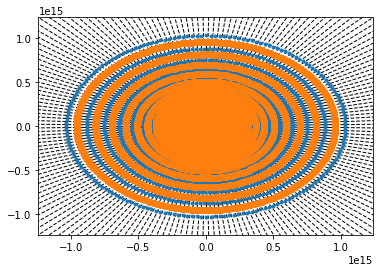

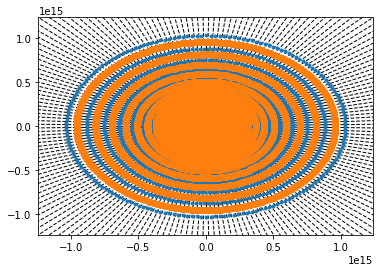

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline

points = [[model2D.x[p], model2D.y[p]] for p in range(model2D.ncells)]
vor    = Voronoi(points)

voronoi_plot_2d(vor)

In [4]:
# Plot model

plot_model_1 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_1.line (model.x, model.density)
plot_model_1.xaxis.axis_label = "x [m]"
plot_model_1.yaxis.axis_label = "density [m^-3]"

plot_model_2 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_2.line (model.x, model.abundance)
plot_model_2.xaxis.axis_label = "x [m]"
plot_model_2.yaxis.axis_label = "abundance [xm^-3]"

plot_model_3 = figure(plot_width=400, plot_height=250)
plot_model_3.line (model.x, model.temperature)
plot_model_3.xaxis.axis_label = "x [m]"
plot_model_3.yaxis.axis_label = "temperature [K]"

plot_model_4 = figure(plot_width=400, plot_height=250)
plot_model_4.line (model.x, model.vx)
plot_model_4.xaxis.axis_label = "x [m]"
plot_model_4.yaxis.axis_label = "velocity_x [m^-3]"

plot_model = gridplot ([[plot_model_1, plot_model_2],[plot_model_3, plot_model_4]])

show (plot_model)

### Read Magritte output

In [5]:
# Read Magritte output

ioFolders = glob(ProjectFolder + 'io/*/')
ioFolders.sort()

inputFolders  = [folder +  'input/' for folder in ioFolders]
outputFolders = [folder + 'output/' for folder in ioFolders]

lastOutput = outputFolders[-1]
lastInput  =  inputFolders[-1]

pops_files = glob(lastOutput + 'populations_0*.txt')
Jeff_files = glob(lastOutput + 'Jeff_0*.txt')
J_files    = glob(lastOutput + 'J_*.txt')
G_files    = glob(lastOutput + 'G_*.txt')
nu_files   = glob(lastOutput + 'frequencies_nu*.txt')
lnr_files  = glob(lastOutput + 'frequencies_line_nr*.txt')
eta_files  = glob(lastOutput + 'eta_0*.txt')
chi_files  = glob(lastOutput + 'chi_0*.txt')

pops_files.sort()
Jeff_files.sort()
eta_files.sort()
chi_files.sort()

pops_3D_data = [np.loadtxt(fileName) for fileName in pops_files]
Jeff_3D_data = [np.loadtxt(fileName) for fileName in Jeff_files]
J_3D_data    = [np.loadtxt(fileName) for fileName in J_files]
G_3D_data    = [np.loadtxt(fileName) for fileName in G_files]
nu_3D_data   = [np.loadtxt(fileName) for fileName in nu_files]
lnr_3D_data  = [np.loadtxt(fileName) for fileName in lnr_files]
eta_3D_data  = [np.loadtxt(fileName) for fileName in eta_files]
chi_3D_data  = [np.loadtxt(fileName) for fileName in chi_files]

# Import linedata
lineData = LineData (ProjectFolder + '/Magritte_files/linedata/hco+.dat')

### Map sphere to 1D model

In [6]:
# Map shpere to 1D model

pops_data = deSphere(cellsInShell, pops_3D_data)
pops_var  = sphereVar(cellsInShell, pops_3D_data)

J_data = deSphere(cellsInShell, J_3D_data)
J_var  = sphereVar(cellsInShell, J_3D_data)

G_data = deSphere(cellsInShell, G_3D_data)
G_var  = sphereVar(cellsInShell, G_3D_data)

Jeff_data = deSphere(cellsInShell, Jeff_3D_data)
Jeff_var  = sphereVar(cellsInShell, Jeff_3D_data)

nu_data = deSphere(cellsInShell, nu_3D_data)
nu_var  = sphereVar(cellsInShell, nu_3D_data)

lnr_data = deSphere(cellsInShell, lnr_3D_data)
lnr_var  = sphereVar(cellsInShell, lnr_3D_data)

#etaR   = deSphere(cellsInShell, eta_data)
#etaVar = sphereVar(cellsInShell, eta_data)

#chiR   = deSphere(cellsInShell, chi_data)
#chiVar = sphereVar(cellsInShell, chi_data)

for s in range(model.ncells):
    #print(f'pops_var  = {np.max(pops_var[0][s])}')
    #print(f'Jeff_var  = {np.max(Jeff_var[0][s])}')
    print(f'J_var     = {np.max(J_var[0][s])}')
    #print(f'nu_var    = {np.max(nu_var[0][s])}')
    #print(f'lnr_var   = {np.max(lnr_var[0][s])}')

#print(np.max(etaVar))
#print(np.max(chiVar))

J_var     = 0.0
J_var     = 4.468956686819215
J_var     = 6.953179120255114
J_var     = 6.405437064109209
J_var     = 1.9277883471292667
J_var     = 2.772681362202118
J_var     = 1.5007867024966153
J_var     = 0.5907573132721954
J_var     = 0.38144243320413423
J_var     = 0.34381137555836283
J_var     = 0.37891422997895124
J_var     = 0.35647995299881813
J_var     = 0.3211967118633996
J_var     = 0.35453386135798526
J_var     = 0.43159056097559156
J_var     = 0.48567373100085326
J_var     = 0.5217113790353384
J_var     = 0.5722360632808233
J_var     = 0.6362499534427447
J_var     = 0.7002024441428116
J_var     = 0.7383241587496372
J_var     = 0.7565256273018485
J_var     = 0.8198931379525921
J_var     = 0.852487082404086
J_var     = 0.8360677400221302
J_var     = 0.8774683740079088
J_var     = 0.889743129195649
J_var     = 0.9128750026808083
J_var     = 0.9607638214617505
J_var     = 0.9327483949988656
J_var     = 0.9281981678125177


In [7]:
J_3D_data[0]

array([[2.75584100e-18, 2.83050242e-18, 3.09263752e-18, ...,
        1.68517652e-27, 1.38879988e-27, 1.03365711e-27],
       [2.74627350e-18, 2.74728453e-18, 2.75546238e-18, ...,
        1.49128710e-27, 1.21329426e-27, 8.79041082e-28],
       [2.74629585e-18, 2.74783832e-18, 2.75923417e-18, ...,
        9.86945374e-28, 7.08951277e-28, 3.74696581e-28],
       ...,
       [2.74630198e-18, 2.74636705e-18, 2.74663846e-18, ...,
        4.47691141e-24, 9.63710717e-25, 1.24340113e-25],
       [2.74629334e-18, 2.74629662e-18, 2.74630057e-18, ...,
        2.04798453e-27, 1.99747469e-27, 1.99301156e-27],
       [2.74629416e-18, 2.74630615e-18, 2.74636089e-18, ...,
        1.52508218e-25, 2.69377591e-26, 4.27337602e-27]])

### Plot output

In [8]:
# Plot functions

def color(s):
    ns = int((s_max-s_min) / s_step + 1)
    es = int((s    -s_min) / s_step)
    return cividis(ns)[es]

def legend(s):
    return f'{s}'

def bokeh_log_plot(title, x, y, xlabel, ylabel):
    return

In [9]:
s_min  = 0
s_max  = model.ncells
s_step = 1

In [10]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nlev)
    y = pops_data[0][s]
    plot.line (x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the level"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

In [11]:
# Mean intensity

plot = figure (title='Total mean intensity', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nrad)
    y = Jeff_data[1][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the transition"
plot.yaxis.axis_label = "mean intensity J [m^-3]"
show(plot)

In [12]:
# Spectrum

plot = figure (title='Spectrum', width=700, height=500, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = nu_data[0][s]
    y =  J_data[0][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

In [13]:
# Flux (G) spectrum

plot = figure (title='Spectrum', width=700, height=500)
for s in range(s_min, s_max, s_step):
    x = nu_data[0][s]
    y =  G_data[0][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

## Compare against RATRAN